# DATA SCIENCE QUESTIONNAIRE


## * Q1: What is the underlying MRT network according to the dataset provided? You should derive the network using only the dataset provided, without referring to other resources, such as the MRT network in Singapore from SMRT, Wiki, Datamall, etc.

## * Q2: Given an origin and destination station pair (say Station A and Station B), how many trains travelled from Station A to Station B in the given dataset?

## * Q3: Suppose a commuter wants to board a train at Clementi Station at 9:25am and alight at Kallang Station. Can you determine the number of people in the train at every station along the path from Clementi to Kallang starting from 9:25am?

 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
get_ipython().magic(u'matplotlib inline')

In [505]:
df = pd.read_csv('mrt_trips_sampled.csv')

# Data Exploration

In [506]:
df.describe()

,index
count,381249.000000
mean,190624.000000
std,110057.250727
min,0.000000
25%,95312.000000
50%,190624.000000
75%,285936.000000
max,381248.000000


In [507]:
# To check if there is any duplicates in index. Maybe there are recurring commuters
len(df.index.unique())

381249

In [508]:
df.describe(include=['object'])

,destination,destination_tm,origin,origin_tm
count,381249,381249,381249,381249
unique,153,7002,154,3600
top,Raffles Place,09:45:29,Ang Mo Kio,09:03:51
freq,22938,189,11898,213


In [509]:
df.isnull().sum()

index             0
destination       0
destination_tm    0
origin            0
origin_tm         0
dtype: int64

In [510]:
df.head()

,index,destination,destination_tm,origin,origin_tm
0,0,Bugis DTL,10:04:47,Stevens,09:52:23
1,1,Kent Ridge,10:11:34,Sengkang,09:27:41
2,2,Tai Seng,09:35:59,Compassvale,09:03:44
3,3,Labrador Park,09:45:50,Bishan NSEW,09:14:45
4,4,Joo Koon,09:27:32,Boon Lay,09:20:36


In [511]:
df.tail()

,index,destination,destination_tm,origin,origin_tm
381244,381244,Promenade,09:48:19,Kembangan,09:21:28
381245,381245,Bugis NSEW,10:09:30,Bedok,09:52:13
381246,381246,HarbourFront NEL,09:51:34,Punggol,09:11:46
381247,381247,one-north,10:14:05,Raffles Place,09:50:38
381248,381248,Orchard,09:40:20,Kovan,09:11:41


In [512]:
# Find the most popular destination
# Find the most popular origin
# Find the most popular time of taking the mrt
# Find the average time people spend at mrt

# Find the detours that people make (to graph how many passengers in a station at a certain timing)

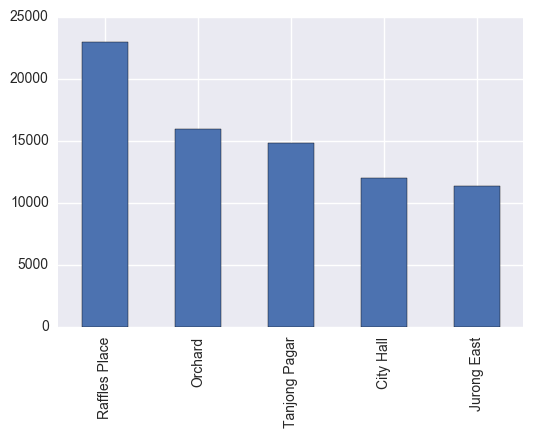

In [513]:
# Find the most visited destination

df.destination.value_counts().head().plot(kind='bar')




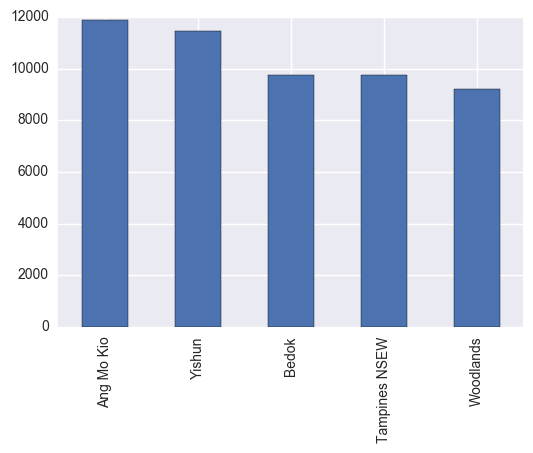

In [514]:
# Find the most visited origin 

df.origin.value_counts().head().plot(kind='bar')

In [515]:
from datetime import timedelta

# df['timeperiod'] = timedelta(df['destination_tm'].str) - timedelta(df['origin_tm'].str)
df['timeperiod'] = pd.to_timedelta(df['destination_tm']) - pd.to_timedelta(df['origin_tm'])



In [516]:
# Change the timeperiod to minute values

df['timeminutetaken'] = df['timeperiod'] / pd.Timedelta('1 minute')



#  Removing of any oddities / abnormalities in the data

### 1. Remove edges where Destination = Origin
### 2. Remove edges where time period is below 1 minute (we assume that it takes at least one minute to tap in and tap out from different station)
### 3. Time period after 2 hours (we assume that it takes max 2 hours longest to travel in the smrt train. If more , then wit will be in case of breakdowns)


In [517]:

samedestination =  df.destination==df.origin
timeperiodbelowone = df.timeminutetaken <1
timeperiodabove120 = df.timeminutetaken >120

In [518]:
print(samedestination.sum())
print(timeperiodbelowone.sum())
print(timeperiodabove120.sum())


2031
636
381


In [519]:

dfclean = df.loc[~samedestination&~timeperiodbelowone&~timeperiodabove120,:]
dfclean.size

  
# ## Use dfclean and filtered same stations destinations (Dhoby Ghaut NSEW etc)

2651187

In [520]:

# Eliminating all second words in this list
findingcapitallettersdestination = dfclean.destination.str.contains(r'(?<![A-Z])[A-Z]{3,}(?![A-Z])')
dfclean.loc[findingcapitallettersdestination,'destination']= [x[0] for x in dfclean.loc[findingcapitallettersdestination,:].destination.str.rsplit(' ',1)]

findingcapitallettersorigin = dfclean.origin.str.contains(r'(?<![A-Z])[A-Z]{3,}(?![A-Z])')
dfclean.loc[findingcapitallettersorigin,'origin']= [x[0] for x in dfclean.loc[findingcapitallettersorigin,:].origin.str.rsplit(' ',1)]


# ## use the dfclean to find central and noncentral origin

C:\Users\Ranon Sim\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [521]:
# Find central origin
dfclean.groupby('origin').timeminutetaken.mean().sort_values(ascending=True).head()



origin
Downtown       12.358642
Newton         12.760173
Telok Ayer     12.960539
Dhoby Ghaut    13.724121
Pending        14.194484
Name: timeminutetaken, dtype: float64

In [522]:
# Find central destination
dfclean.groupby('destination').timeminutetaken.mean().sort_values(ascending=True).head()

destination
Sam Kee     6.716667
Bangkit    10.844718
Petir      11.707619
Kangkar    11.871141
Pending    12.173958
Name: timeminutetaken, dtype: float64

In [524]:
# What are the possible origins and destinations unique values (listing of stations)
# df.destination.unique()
# df.origin.unique()
dfclean.destination.unique() 

array(['Bugis', 'Kent Ridge', 'Tai Seng', 'Labrador Park', 'Joo Koon',
       'Choa Chu Kang', 'Sembawang', 'Fernvale', 'Clarke Quay',
       'Tanjong Pagar', 'Newton', 'one-north', 'Segar', 'Clementi',
       'Khatib', 'Fajar', 'Boon Lay', 'Orchard', 'Tiong Bahru',
       'Chinatown', 'Jurong East', 'Lorong Chuan', 'Toa Payoh',
       'HarbourFront', 'Dhoby Ghaut', 'Promenade', 'Pioneer',
       'Buona Vista', 'Stadium', 'Woodlands', 'Sengkang', 'Pasir Panjang',
       'Lavender', 'Queenstown', 'Kallang', 'Raffles Place',
       'Nicoll Highway', 'Tampines', 'Outram Park', 'Potong Pasir',
       'City Hall', 'Tanah Merah', 'Somerset', 'Dover', 'Buangkok',
       'Admiralty', 'Serangoon', 'Yew Tee', 'Downtown', 'Farrer Road',
       'Aljunied', 'Bayfront', 'MacPherson', 'Teck Whye', 'Yio Chu Kang',
       'King Albert Park', 'Bukit Batok', 'Changi Airport', 'Paya Lebar',
       'Damai', 'Ang Mo Kio', 'Expo', 'Sixth Avenue', 'Holland Village',
       'Bukit Gombak', 'Bishan', 'Lakeside'

In [541]:
stationdf = pd.DataFrame()


In [542]:
### STATIONDF = LIST OF UNIQUE STATIONS ACROSS BOTH ORIGINS & DESTINATIONS 
## Destination stations are basically a subset of origin stations 

stationdf['station']=dfclean.origin.unique()

In [543]:
stationdf

,station
0,Stevens
1,Sengkang
2,Compassvale
3,Bishan
4,Boon Lay
5,Khatib
6,Woodlands
7,Chinatown
8,Newton
9,Tampines


In [544]:
stationdfset = stationdf.set_index('station')

In [545]:
## Average Travel time from other stations to destination station X 
stationdfset['minutetakenasdestination'] =  dfclean.groupby('destination').timeminutetaken.mean()
## Average Travel time from  origin station X to other stations  
stationdfset['minutetakenasorigin'] = dfclean.groupby('origin').timeminutetaken.mean()
## Total Traffic Count from other stations to destination station X 
stationdfset['counttrafficdestination'] = dfclean.groupby('destination').timeminutetaken.count()
## Total Traffic Count from origin station X to other stations  
stationdfset['counttrafficorigin'] = dfclean.groupby('origin').timeminutetaken.count()

In [546]:
stationdfset.head()


,minutetakenasdestination,minutetakenasorigin,counttrafficdestination,counttrafficorigin
station,,,,
Stevens,16.712917,15.587724,240.0,615
Sengkang,16.407068,27.209650,1620.0,7518
Compassvale,14.277932,30.783237,324.0,1038
Bishan,21.096509,20.697984,4368.0,9522
Boon Lay,30.276859,31.532094,5043.0,7302


In [547]:
stationdfset.describe()

C:\Users\Ranon Sim\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,minutetakenasdestination,minutetakenasorigin,counttrafficdestination,counttrafficorigin
count,136.000000,137.000000,136.000000,137.000000
mean,22.697031,23.485623,2784.816176,2764.532847
std,5.440983,6.414214,3545.437227,2875.901360
min,10.844718,12.358642,21.000000,6.000000
25%,NaN,18.377602,NaN,603.000000
50%,NaN,22.403333,NaN,1344.000000
75%,NaN,28.672864,NaN,4203.000000
max,42.637337,42.998703,22899.000000,12525.000000


In [548]:
# Finding out popularity of the stations based on the counttraffic destination and origin.  
stationdfset['destinationpopularity'] = pd.qcut(stationdfset['counttrafficdestination'],3,labels=['low','med','high'])
stationdfset['originpopularity'] = pd.qcut(stationdfset['counttrafficorigin'],3,labels=['low','med','high'])


In [549]:
 
stationdfset.head()


,minutetakenasdestination,minutetakenasorigin,counttrafficdestination,counttrafficorigin,destinationpopularity,originpopularity
station,,,,,,
Stevens,16.712917,15.587724,240.0,615,low,low
Sengkang,16.407068,27.209650,1620.0,7518,med,high
Compassvale,14.277932,30.783237,324.0,1038,low,med
Bishan,21.096509,20.697984,4368.0,9522,high,high
Boon Lay,30.276859,31.532094,5043.0,7302,high,high


In [550]:

# ASSUMPTION: Central Stations are on the medium to high scale in terms of traffic (both to and from the stations)
medhighcounts = (stationdfset.destinationpopularity.isin(['med','high']))&(stationdfset.originpopularity.isin(['med','high']))


In [551]:


stationdfset.loc[medhighcounts,'minutetakenasdestination'].sort_values().head()


station
Bukit Panjang    15.432504
Sengkang         16.407068
Kovan            17.098517
Punggol          18.517269
Boon Keng        18.915853
Name: minutetakenasdestination, dtype: float64

In [552]:


stationdfset.loc[medhighcounts,'minutetakenasorigin'].sort_values().head(10)


station
Newton             12.760173
Dhoby Ghaut        13.724121
Rochor             14.842075
City Hall          15.077724
Somerset           15.214431
Bugis              15.772403
Botanic Gardens    15.869775
Little India       15.954053
Boon Keng          16.712680
Novena             16.848516
Name: minutetakenasorigin, dtype: float64

# Find distinct count of stations that visited the following station.

In [603]:

stationdfset['stationsvisitingthisstation'] = dfclean.groupby('destination').origin.nunique()



In [604]:

stationdfset.head()

,minutetakenasdestination,minutetakenasorigin,counttrafficdestination,counttrafficorigin,destinationpopularity,originpopularity,countdistinctstationvisited,stationsvisitingthisstation
station,,,,,,,,
Stevens,16.712917,15.587724,240.0,615,low,low,34.0,34.0
Sengkang,16.407068,27.209650,1620.0,7518,med,high,71.0,71.0
Compassvale,14.277932,30.783237,324.0,1038,low,med,29.0,29.0
Bishan,21.096509,20.697984,4368.0,9522,high,high,108.0,108.0
Boon Lay,30.276859,31.532094,5043.0,7302,high,high,98.0,98.0


In [605]:


stationsvisitingthisstationmorethan10 = stationdfset.stationsvisitingthisstation>10


In [606]:
# Top 5 Central Destinations
firstfivedest = stationdfset.loc[medhighcounts&stationsvisitingthisstationmorethan10,'minutetakenasdestination'].sort_values().head(5)
firstfivedest.index.get_values()

array(['Bukit Panjang', 'Sengkang', 'Kovan', 'Punggol', 'Boon Keng'], dtype=object)

In [607]:
# Top 5 Central Origins

firstfiveorigin = stationdfset.loc[medhighcounts&stationsvisitingthisstationmorethan10,'minutetakenasorigin'].sort_values().head(5)
firstfiveorigin.index.get_values()

array(['Newton', 'Dhoby Ghaut', 'Rochor', 'City Hall', 'Somerset'], dtype=object)

In [608]:
# Top 5 End - Destinations

lastfivedest = stationdfset.loc[medhighcounts&stationsvisitingthisstationmorethan10,'minutetakenasdestination'].sort_values().tail(5)
lastfivedest.index.get_values()


array(['Kent Ridge', 'Dover', 'HarbourFront', 'Haw Par Villa',
       'Changi Airport'], dtype=object)

In [609]:
# Top 5 End - Origins

lastfiveori = stationdfset.loc[medhighcounts&countdistinctstationvisitedmorethan10,'minutetakenasorigin'].sort_values().tail(5)
lastfiveori.index.get_values()


array(['Admiralty', 'Tampines', 'Woodlands', 'Fernvale', 'Changi Airport'], dtype=object)

In [610]:
centralnodes = list(set(firstfivedest.index.get_values()) | set(firstfiveorigin.index.get_values()))
centralnodes

['Newton',
 'Boon Keng',
 'Somerset',
 'Sengkang',
 'Dhoby Ghaut',
 'Bukit Panjang',
 'Rochor',
 'Punggol',
 'City Hall',
 'Kovan']

In [611]:


endnodes = list(set(lastfivedest.index.get_values()) | set(lastfiveori.index.get_values()))
endnodes

['Haw Par Villa',
 'HarbourFront',
 'Dover',
 'Woodlands',
 'Fernvale',
 'Kent Ridge',
 'Tampines',
 'Changi Airport',
 'Admiralty']

In [612]:



# # Next steps
# 1. Finding the route with shortest time from any centres to the end nodes 
# 2. Finding the inbetweens of that route (by checking center to node, node to end)
# 3. Repeating that system with the other possible alternatives


In [613]:
stationincentralnodes = (dfclean.destination.isin(centralnodes))&(dfclean.origin.isin(endnodes))|(dfclean.destination.isin(endnodes))&(dfclean.origin.isin(centralnodes))
                       


In [572]:
(stationincentralnodes).sum()

7092

In [573]:
dfclean.loc[stationincentralnodes,:].head()


,index,destination,destination_tm,origin,origin_tm,timeperiod,timeminutetaken
1,1,Kent Ridge,10:11:34,Sengkang,09:27:41,00:43:53,43.883333
33,33,HarbourFront,10:13:20,Dhoby Ghaut,09:55:37,00:17:43,17.716667
64,64,City Hall,09:36:51,Tampines,09:04:11,00:32:40,32.666667
66,66,Dhoby Ghaut,10:14:39,Woodlands,09:33:30,00:41:09,41.150000
96,96,Dhoby Ghaut,10:10:07,Haw Par Villa,09:43:44,00:26:23,26.383333


In [574]:
timebyorigindestination = dfclean.loc[stationincentralnodes,:].groupby(['origin','destination']).timeminutetaken.mean()


In [575]:
# Use this centralnodesdf to find the inbetweens. This we will create a set of existing nodes (outside the pair and find the neighbour until a chain is formed
centralendnodesdf = timebyorigindestination.sort_values().reset_index()
centralendnodesdf.head()



     

,origin,destination,timeminutetaken
0,Sengkang,Fernvale,12.761789
1,Fernvale,Sengkang,13.239247
2,HarbourFront,Dhoby Ghaut,13.719231
3,Dhoby Ghaut,HarbourFront,14.814754
4,Fernvale,Punggol,17.308333


In [576]:
existingstations = list(set(dfclean.destination.get_values()) | set(dfclean.origin.get_values()))

In [577]:
# This is the matrix which will be used to find neighbors

origindestinationminutetaken = dfclean.groupby(['origin','destination']).timeminutetaken.mean().reset_index()

origindestinationminutetaken

,origin,destination,timeminutetaken
0,Admiralty,Aljunied,54.225758
1,Admiralty,Ang Mo Kio,22.035294
2,Admiralty,Bartley,34.966667
3,Admiralty,Bayfront,53.339474
4,Admiralty,Bedok,56.683333
5,Admiralty,Bishan,26.139344
6,Admiralty,Boon Keng,45.030000
7,Admiralty,Boon Lay,39.668137
8,Admiralty,Botanic Gardens,40.691667
9,Admiralty,Braddell,28.303571



## Qn 1
### Finding the network

In [579]:
# Getting the time of the node1 and node2
# Assumption direction does not matter  (mean approach)
def getnode1andnode2time (node1,node2):
    nodeset = [node1,node2]
    startendwithinorigin = (origindestinationminutetaken.origin.isin(nodeset))
    startendwithindestination = (origindestinationminutetaken.destination.isin(nodeset))

    return origindestinationminutetaken.loc[startendwithinorigin&startendwithindestination,:].timeminutetaken.median()


In [580]:

# Create a chain of network using the existing nodes

def chainingexistingnode(existingstations,existingchain):
#     Remove starting existing_node in existingchain
    existing_nodes = list(existingstations)
    existing_nodes.remove(existingchain[0])
    existing_nodes.remove(existingchain[1])
    for node in existing_nodes:
        for i in range(0,len(existingchain)-1):
            chain=existingchain
            start,end = chain[i],chain[i+1]
            startendtime = getnode1andnode2time(start,end)
            startnodetime = getnode1andnode2time(start,node)
            endnodetime = getnode1andnode2time(node,end)
            if (startnodetime<startendtime )&(endnodetime<startendtime)&~(node in existingchain):
                existingchain.insert(i+1,node)
    
    return existingchain



# Proof of concept:

In [581]:

# Let's say that in between dhoby ghaut and harbourfront there is chinatown
# First we need to find the time from dhoby ghaut to harbourfront
chaintime = getnode1andnode2time('HarbourFront','Dhoby Ghaut')
# then we find the time from Chinatown to harbourfront and dhobyghaut to chinatown
chtime = getnode1andnode2time('HarbourFront','Chinatown')
dctime =getnode1andnode2time('Dhoby Ghaut','Chinatown')

print(chaintime)
print(chtime)
print(dctime)

# Therefore since the both the time is in between 
# Chinatown should be put inside the chain
# Then the possible start and end of the chain will now include, harborfront-->Chinatown and DhobyGhaut--> Chinatown


13.719230769230771
10.178657074340535
7.919246031746031


In [582]:

# chainingexistingnode

finalchain = chainingexistingnode(existingstations,['HarbourFront','Dhoby Ghaut'])


In [583]:
finalchain

['HarbourFront', 'Outram Park', 'Clarke Quay', 'Dhoby Ghaut']

## Segments 584 to 587 are for q3.
###  Adding on clementi and kallang for qn3



In [614]:
centralendnodesdf.loc[-1] = ['Clementi','Kallang',0]


In [615]:
centralendnodesdf.index=centralendnodesdf.index+1


In [616]:

centralendnodesdf.sort(inplace=True)


# ## Repeat this procedure and change the existingnodes to the rows by centralendnodesdf


C:\Users\Ranon Sim\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  from ipykernel import kernelapp as app


In [617]:
listofstartandend = centralendnodesdf.as_matrix(columns=['origin','destination']).tolist()


In [619]:
# Find list of tuples
def tuplelistfromchain(chains):
    tuplelist = []
    for chain in chains:
        for i in range(0,len(chain)-1):
            tuplelist.append((chain[i],chain[i+1]))
    return tuplelist

### GENERATING THE MRT NETWORK VISUALIZATION 

Nodes of graph: 
['Marymount', 'Newton', 'Dover', 'Somerset', 'Bishan', 'Dhoby Ghaut', 'Novena', 'Farrer Park', 'Thanggam', 'Clarke Quay', 'Buangkok', 'City Hall', 'Bugis', 'South View', 'Cheng Lim', 'Clementi', 'Orchard', 'Rochor', 'HarbourFront', 'Farrer Road', 'Paya Lebar', 'Botanic Gardens', 'Sam Kee', 'Layar', 'Renjong', 'Sengkang', 'Kallang', 'Holland Village', 'Fernvale', 'Tongkang', 'Punggol', 'Boon Keng', 'Caldecott', 'Lavender', 'Toa Payoh', 'Raffles Place', 'Petir', 'Farmway', 'Braddell', 'Buona Vista', 'Little India', 'Outram Park']
Edges of graph: 
[('Marymount', 'Caldecott'), ('Marymount', 'Bishan'), ('Newton', 'Novena'), ('Newton', 'Rochor'), ('Newton', 'Little India'), ('Newton', 'Dhoby Ghaut'), ('Dover', 'Clementi'), ('Dover', 'Buona Vista'), ('Somerset', 'City Hall'), ('Somerset', 'Orchard'), ('Bishan', 'Braddell'), ('Dhoby Ghaut', 'Cheng Lim'), ('Dhoby Ghaut', 'Little India'), ('Dhoby Ghaut', 'Clarke Quay'), ('Novena', 'Toa Payoh'), ('Farrer Park', 'Boon Keng'), ('Fa

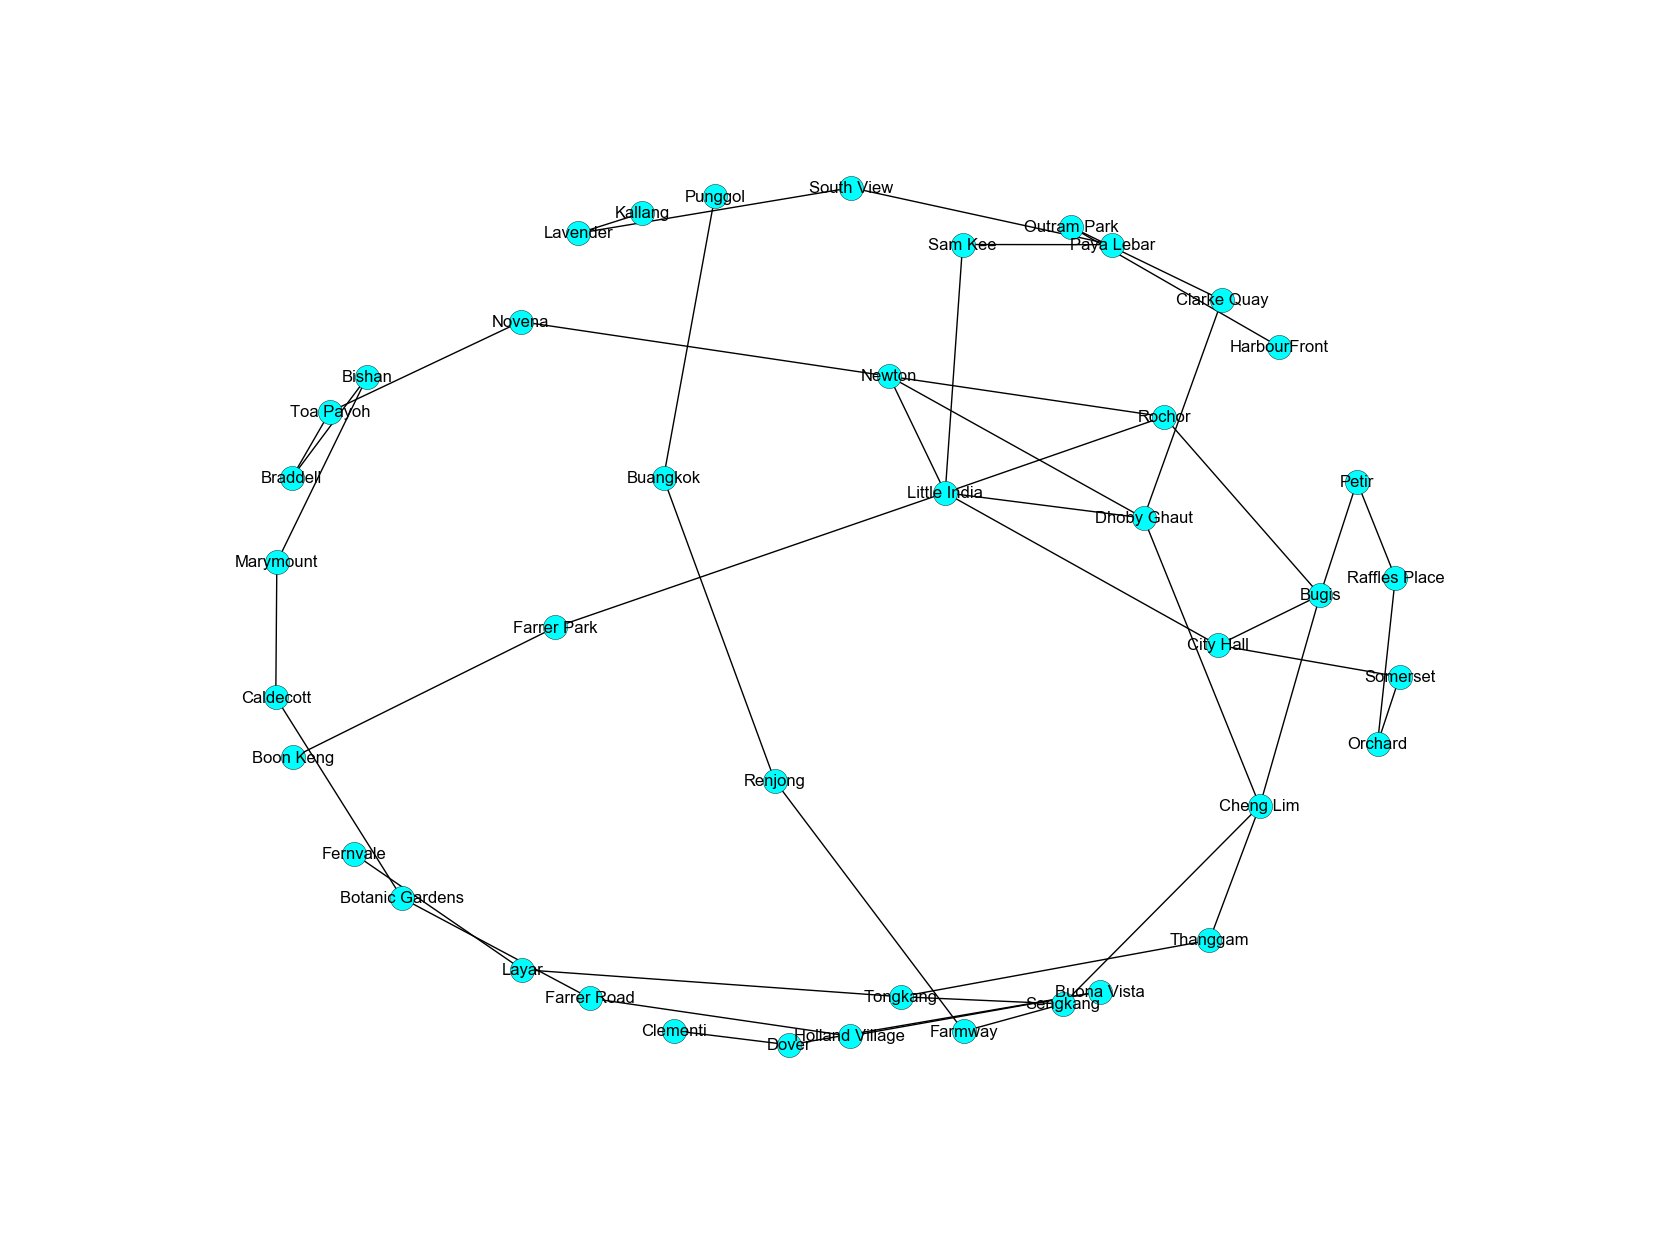

Wall time: 649 ms


In [620]:

get_ipython().run_cell_magic(u'time', u'', u'\nimport networkx as nx\n\nG=nx.Graph()\n# G.add_nodes_from(existingstations)\n\n# adding a list of edges:\nG.add_edges_from(tuplelistfromchain(chains[:10]))\n\nusedstations = G.nodes()\nusededges = G.edges()\n\nprint("Nodes of graph: ")\nprint(usedstations)\nprint("Edges of graph: ")\nprint(usededges)\n \nplt.figure(figsize=(16,12)) \nnx.draw(G, node_size = 300, node_color="cyan", with_labels = True)\nplt.savefig("simple_path.png") # save as png\nplt.show() # display')


## QUESTION 2 


### Approach 
#### 1. Specify relevant chains that has station A and B 
#### 2. Find the demand of the connections in between A to B (Includes pairs of the destinations)
#### 3. Connections would include all the chains that goes before A 
#### 4. Perform blocking of the train capacity based on on peak and off peak timing
#### *Estimation of Trains Travelled = Number of passengers along the path from A to B /  Train Capacity*

### Assumptions
#### 1. Capacity during rush hours (7.30-9.30am,5.30pm-7.30pm ) --> Assuming full capacity of trains
#### 2. Capacity during non rush hours ()
#### 3. How many people can fit in mrt?
#### 4. One way directions

## GLOBAL NODES - INPUT STATION & STATION B HERE FOR Q2

In [621]:

globalnodea='Kovan'
globalnodeb='Botanic Gardens'

In [622]:
# generate relevantchains
def generaterelevantchains(chainlist,startnode,endnode):
    chainchosens = []  
    for chain in chainlist:
    #     Getting the chain
        if (startnode in chain) & (endnode in chain):
            chainchosens.append(chain)
    return chainchosens


In [623]:
# Remove redundancy i.e. chains that are repeated but with order switched around
def removelistredundancy(relevantchains):
    for i in range(0,len(relevantchains)-1):
        for j in range(i,len(relevantchains)-1):
            if set(relevantchains[i])==set(relevantchains[j]):
                relevantchains.remove(relevantchains[i])
    return relevantchains



In [624]:
# DATAFRAME OF TRAFFIC COUNT FOR EVERY UNIQUE EDGE 
origindestinationtraffic = dfclean.groupby(['origin','destination']).count().timeperiod.reset_index().rename(columns={'timeperiod':'counttraffic'})

## METHOD TO COUNT TRAFFIC BETWEEN EDGES
def getnode1andnode2traffic (node1,node2):
    nodeset = [node1,node2]
    startendwithinorigin = (origindestinationtraffic.origin==node1)&(origindestinationtraffic.destination==node2)

    try:
        return origindestinationtraffic.loc[startendwithinorigin,:].counttraffic.values[0]
    except:
        return 0

In [625]:
    startendwithinorigin = (origindestinationtraffic.origin==globalnodea)&(origindestinationtraffic.destination==globalnodeb)
    origindestinationtraffic[startendwithinorigin]


,origin,destination,counttraffic
4634,Kovan,Botanic Gardens,21


In [626]:

## PROOF OF CONCEPT TO CALCULATE TRAFFIC BETWEEN NODE A & NODE B 

getnode1andnode2traffic(globalnodea,globalnodeb)



21

In [627]:
# Buona vista to dover connection
# connection = sum(traffic er RD,TD,BD)

def findEdgeTraffic(chain,nodea,nodeb):
    edgetraffic=0
    lhs=chain[:chain.index(nodea)+1]
    rhs=chain[chain.index(nodeb):]
    for node1 in lhs:
        for node2 in rhs:
            edgetraffic+=getnode1andnode2traffic(node1,node2)
    return edgetraffic


In [628]:


# Getting max connection from globenodea and globenodeb
def findingthemaxedge(travelchain,nodea,nodeb):
    edgelist=[]

    nodeatonodeb = travelchain[travelchain.index(nodea):travelchain.index(nodeb)+1]
    if nodeatonodeb ==[]:
        tchain=list(travelchain)
        nodeatonodeb = tchain.reverse()[tchain.index(nodeb):tchain.index(nodea)+1]
        
    tuplelist = [(nodeatonodeb[i],nodeatonodeb[i+1]) for i in range(0,len(nodeatonodeb)-1)]

    for tuple in tuplelist:
        edgelist.append(findEdgeTraffic(travelchain,tuple[0],tuple[1]))
        print('from: '+str(tuple[0])+',to '+str(tuple[1])+':'+str(findEdgeTraffic(travelchain,tuple[0],tuple[1])))
#     print(edgelist)
    return max(edgelist)
    
# findingthemaxconnection (travelchain,globalnodea,globalnodeb)


# # All the chains of relevant stations

In [629]:
def demandsofchain(chains,globalnodea,globalnodeb):
    totalnumberofdemands=0
    relevantoriginalchains = removelistredundancy(generaterelevantchains(chains,globalnodea,globalnodeb))
    for chain in relevantoriginalchains:
        totalnumberofdemands += findingthemaxedge(chain,globalnodea,globalnodeb)

    return totalnumberofdemands


In [630]:
totalDemandOfChains = demandsofchain(chains,globalnodea,globalnodeb)

# ## To consider on peak and off peak
# 1. On peak =4 hours
# 2. Train hours = 18 hours
# 3. Therefore, offpeak hours =14 hours
# 4. onpeak = 95% demands
# 5. offpeak = 75% * onpeak
# 
# Train capacity
# 1. 100 - at full capacity (sample)

print(totalDemandOfChains)

0


In [631]:
onpeak = totalDemandOfChains*0.95
offpeak = onpeak*0.75
print(onpeak)
print(offpeak)
# totaldemand =  onpeak + proportionateofoffpeak*offpeak (buffer)
totaldemand = onpeak+(float(14)/18)*offpeak
print ("Total Trains Travelled Between:" totaldemand

SyntaxError: invalid syntax (<ipython-input-631-ef4d065626e4>, line 7)

## Q2 ANSWER : TRAINS TRAVELLED 

In [632]:
import math

Q2 = math.ceil(totaldemand/931)
print("Total Trains Travelled between: " + globalnodea +" & " + globalnodeb + " = " + str(Q2))



Total Trains Travelled between: Kovan & Botanic Gardens = 3


## QUESTION 3 

Suppose a commuter wants to board at clementi and alight at kallang station. Can you determine the number of people in the train at every station along the path from clementi ato kallang starting from 9.25 am?


In [633]:
import math
capacityonetrain = 900
totalnumberoftrains = totaldemand/capacityonetrain
print(math.ceil(totalnumberoftrains))



3


In [634]:

# nodea='Clementi'
# nodeb='Kallang'
# print(demandsofchain(chains,nodea,nodeb))


# 1. Assigning timewindow of each station in the chain
# 2. Filtering the people in each chain
# 3. Use the chain to find the number of people within each station



## ASSUMPTION: 
#### There is only one path to consider in between the two nodes -> If there's more than one path, we just pick one for a proof of concept
#### The likelihood of there being >1 path isn't very large

In [635]:

globalnodea='Clementi'
globalnodeb='Kallang'
chain= removelistredundancy(generaterelevantchains(chains,globalnodea,globalnodeb))[0]



In [636]:
startingtime=datetime.strptime('09:25:00','%H:%M:%S')
for i in range(0,len(chain)-1):
    dfclean.loc[(dfclean.origin==chain[i]),'timewindowstart'] = startingtime+pd.Timedelta(minutes=getnode1andnode2time (chain[i],chain[i+1])*i)
    dfclean.loc[(dfclean.origin==chain[i]),'timewindowend'] = startingtime+pd.Timedelta(minutes=getnode1andnode2time (chain[i],chain[i+1])*(i+1))



C:\Users\Ranon Sim\Anaconda3\lib\site-packages\pandas\core\indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Ranon Sim\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [637]:
dfclean.loc[:,'timedateorigin']=pd.to_datetime(dfclean.origin_tm,format='%H:%M:%S')


C:\Users\Ranon Sim\Anaconda3\lib\site-packages\pandas\core\indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Ranon Sim\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [638]:
# Filling in the gap of timewindowstart and timewindowend
dfclean=dfclean.fillna(0)


In [639]:
timeoriginisinbetween= (dfclean.timewindowstart<dfclean.timedateorigin)&(dfclean.timedateorigin<dfclean.timewindowend)
dfclean=dfclean.loc[timeoriginisinbetween,:]



In [640]:

dfclean

,index,destination,destination_tm,origin,origin_tm,timeperiod,timeminutetaken,timewindowstart,timewindowend,timedateorigin
500,500,Jurong East,09:37:28,Clementi,09:28:13,00:09:15,9.250000,1900-01-01 09:25:00.000000,1900-01-01 09:31:55.025794,1900-01-01 09:28:13
512,512,Kent Ridge,09:43:59,Buona Vista,09:36:33,00:07:26,7.433333,1900-01-01 09:33:54.603030,1900-01-01 09:38:21.904545,1900-01-01 09:36:33
734,734,HarbourFront,10:01:41,Clementi,09:30:31,00:31:10,31.166667,1900-01-01 09:25:00.000000,1900-01-01 09:31:55.025794,1900-01-01 09:30:31
1823,1823,Raffles Place,09:56:44,Clementi,09:30:41,00:26:03,26.050000,1900-01-01 09:25:00.000000,1900-01-01 09:31:55.025794,1900-01-01 09:30:41
1914,1914,Chinatown,09:52:02,Clementi,09:25:31,00:26:31,26.516667,1900-01-01 09:25:00.000000,1900-01-01 09:31:55.025794,1900-01-01 09:25:31
2295,2295,Orchard,10:07:13,Clementi,09:31:38,00:35:35,35.583333,1900-01-01 09:25:00.000000,1900-01-01 09:31:55.025794,1900-01-01 09:31:38
2976,2976,Pasir Ris,10:44:02,Farrer Road,09:52:17,00:51:45,51.750000,1900-01-01 09:47:48.571429,1900-01-01 09:53:30.714286,1900-01-01 09:52:17
3199,3199,one-north,09:39:42,Clementi,09:25:32,00:14:10,14.166667,1900-01-01 09:25:00.000000,1900-01-01 09:31:55.025794,1900-01-01 09:25:32
3694,3694,Bedok,10:28:16,Caldecott,09:55:57,00:32:19,32.316667,1900-01-01 09:51:51.800000,1900-01-01 09:56:20.433333,1900-01-01 09:55:57
3965,3965,Yio Chu Kang,10:12:36,Holland Village,09:45:52,00:26:44,26.733333,1900-01-01 09:41:38.576555,1900-01-01 09:47:11.435407,1900-01-01 09:45:52


In [641]:
# new traffic
origindestinationtraffic = dfclean.groupby(['origin','destination']).count().timeperiod.reset_index().rename(columns={'timeperiod':'counttraffic'})


In [642]:


origindestinationtraffic.head()


,origin,destination,counttraffic
0,Botanic Gardens,Buona Vista,3
1,Botanic Gardens,Newton,6
2,Botanic Gardens,Yio Chu Kang,3
3,Botanic Gardens,one-north,3
4,Buona Vista,Aljunied,3


# Q3 Answer:

In [643]:
print(demandsofchain(chains,globalnodea,globalnodeb))


from: Clementi,to Dover:210
from: Dover,to Buona Vista:237
from: Buona Vista,to Holland Village:225
from: Holland Village,to Farrer Road:237
from: Farrer Road,to Botanic Gardens:240
from: Botanic Gardens,to Caldecott:237
from: Caldecott,to Marymount:240
from: Marymount,to Bishan:234
from: Bishan,to Braddell:225
from: Braddell,to Toa Payoh:222
from: Toa Payoh,to Novena:219
from: Novena,to Newton:210
from: Newton,to Dhoby Ghaut:195
from: Dhoby Ghaut,to Cheng Lim:186
from: Cheng Lim,to Bugis:186
from: Bugis,to Petir:153
from: Petir,to Raffles Place:153
from: Raffles Place,to Orchard:99
from: Orchard,to Somerset:84
from: Somerset,to City Hall:69
from: City Hall,to Little India:33
from: Little India,to Sam Kee:24
from: Sam Kee,to Paya Lebar:24
from: Paya Lebar,to South View:15
from: South View,to Lavender:15
from: Lavender,to Kallang:0
240


# END 